In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,PowerTransformer
from sklearn.linear_model import LinearRegression,LassoCV,LogisticRegression
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import KFold,train_test_split,StratifiedKFold,GridSearchCV,cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,accuracy_score, \
                            precision_score,recall_score, roc_auc_score
import warnings
from scipy import stats
warnings.filterwarnings('ignore')

1.1 字段名称描述

Pregnancies	怀孕次数

Glucose	血糖浓度

BloodPressure	血压值

SkinThickness	皮肤厚度

Insulin	胰岛素量

BMI	体重指数

DiabetesPedigreeFunction 糖尿病谱系函数

Age	年龄

Outcome	结果

In [2]:
import os
# os.chdir(os.getcwd()+'\\data')
print(os.getcwd())

d:\mypython\ml\机器学习\糖尿病


In [3]:
train_data = pd.read_csv('diabetes.csv')
# 为方便查看调整列名为中文
train_data.rename(columns = {'Pregnancies':'怀孕次数', 'Glucose':'血糖浓度', 'BloodPressure':'血压值',
       'SkinThickness':'皮肤厚度', 'Insulin':'胰岛素量', 'BMI':'体重指数',
       'DiabetesPedigreeFunction':'糖尿病谱系函数', 'Age':'年龄',
       'Outcome':'结果'},inplace=True)
print(train_data.info())
print(train_data.head().T)
train_data.describe().T

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   怀孕次数     768 non-null    int64  
 1   血糖浓度     768 non-null    int64  
 2   血压值      768 non-null    int64  
 3   皮肤厚度     768 non-null    int64  
 4   胰岛素量     768 non-null    int64  
 5   体重指数     768 non-null    float64
 6   糖尿病谱系函数  768 non-null    float64
 7   年龄       768 non-null    int64  
 8   结果       768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB
None
               0       1        2       3        4
怀孕次数       6.000   1.000    8.000   1.000    0.000
血糖浓度     148.000  85.000  183.000  89.000  137.000
血压值       72.000  66.000   64.000  66.000   40.000
皮肤厚度      35.000  29.000    0.000  23.000   35.000
胰岛素量       0.000   0.000    0.000  94.000  168.000
体重指数      33.600  26.600   23.300  28.100   43.100
糖尿病谱系函数    0.627   0.351    0.672   0.167    2.288
年龄        50.0

,count,mean,std,min,25%,50%,75%,max
怀孕次数,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
血糖浓度,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
血压值,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
皮肤厚度,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
胰岛素量,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
体重指数,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
糖尿病谱系函数,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
年龄,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
结果,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [4]:
# 类别分布相对不平衡，可能会影响建模效果
print(train_data.结果.value_counts())

# 观察缺失值数,无缺失值
train_data.isnull().sum()

0    500
1    268
Name: 结果, dtype: int64


怀孕次数       0
血糖浓度       0
血压值        0
皮肤厚度       0
胰岛素量       0
体重指数       0
糖尿病谱系函数    0
年龄         0
结果         0
dtype: int64

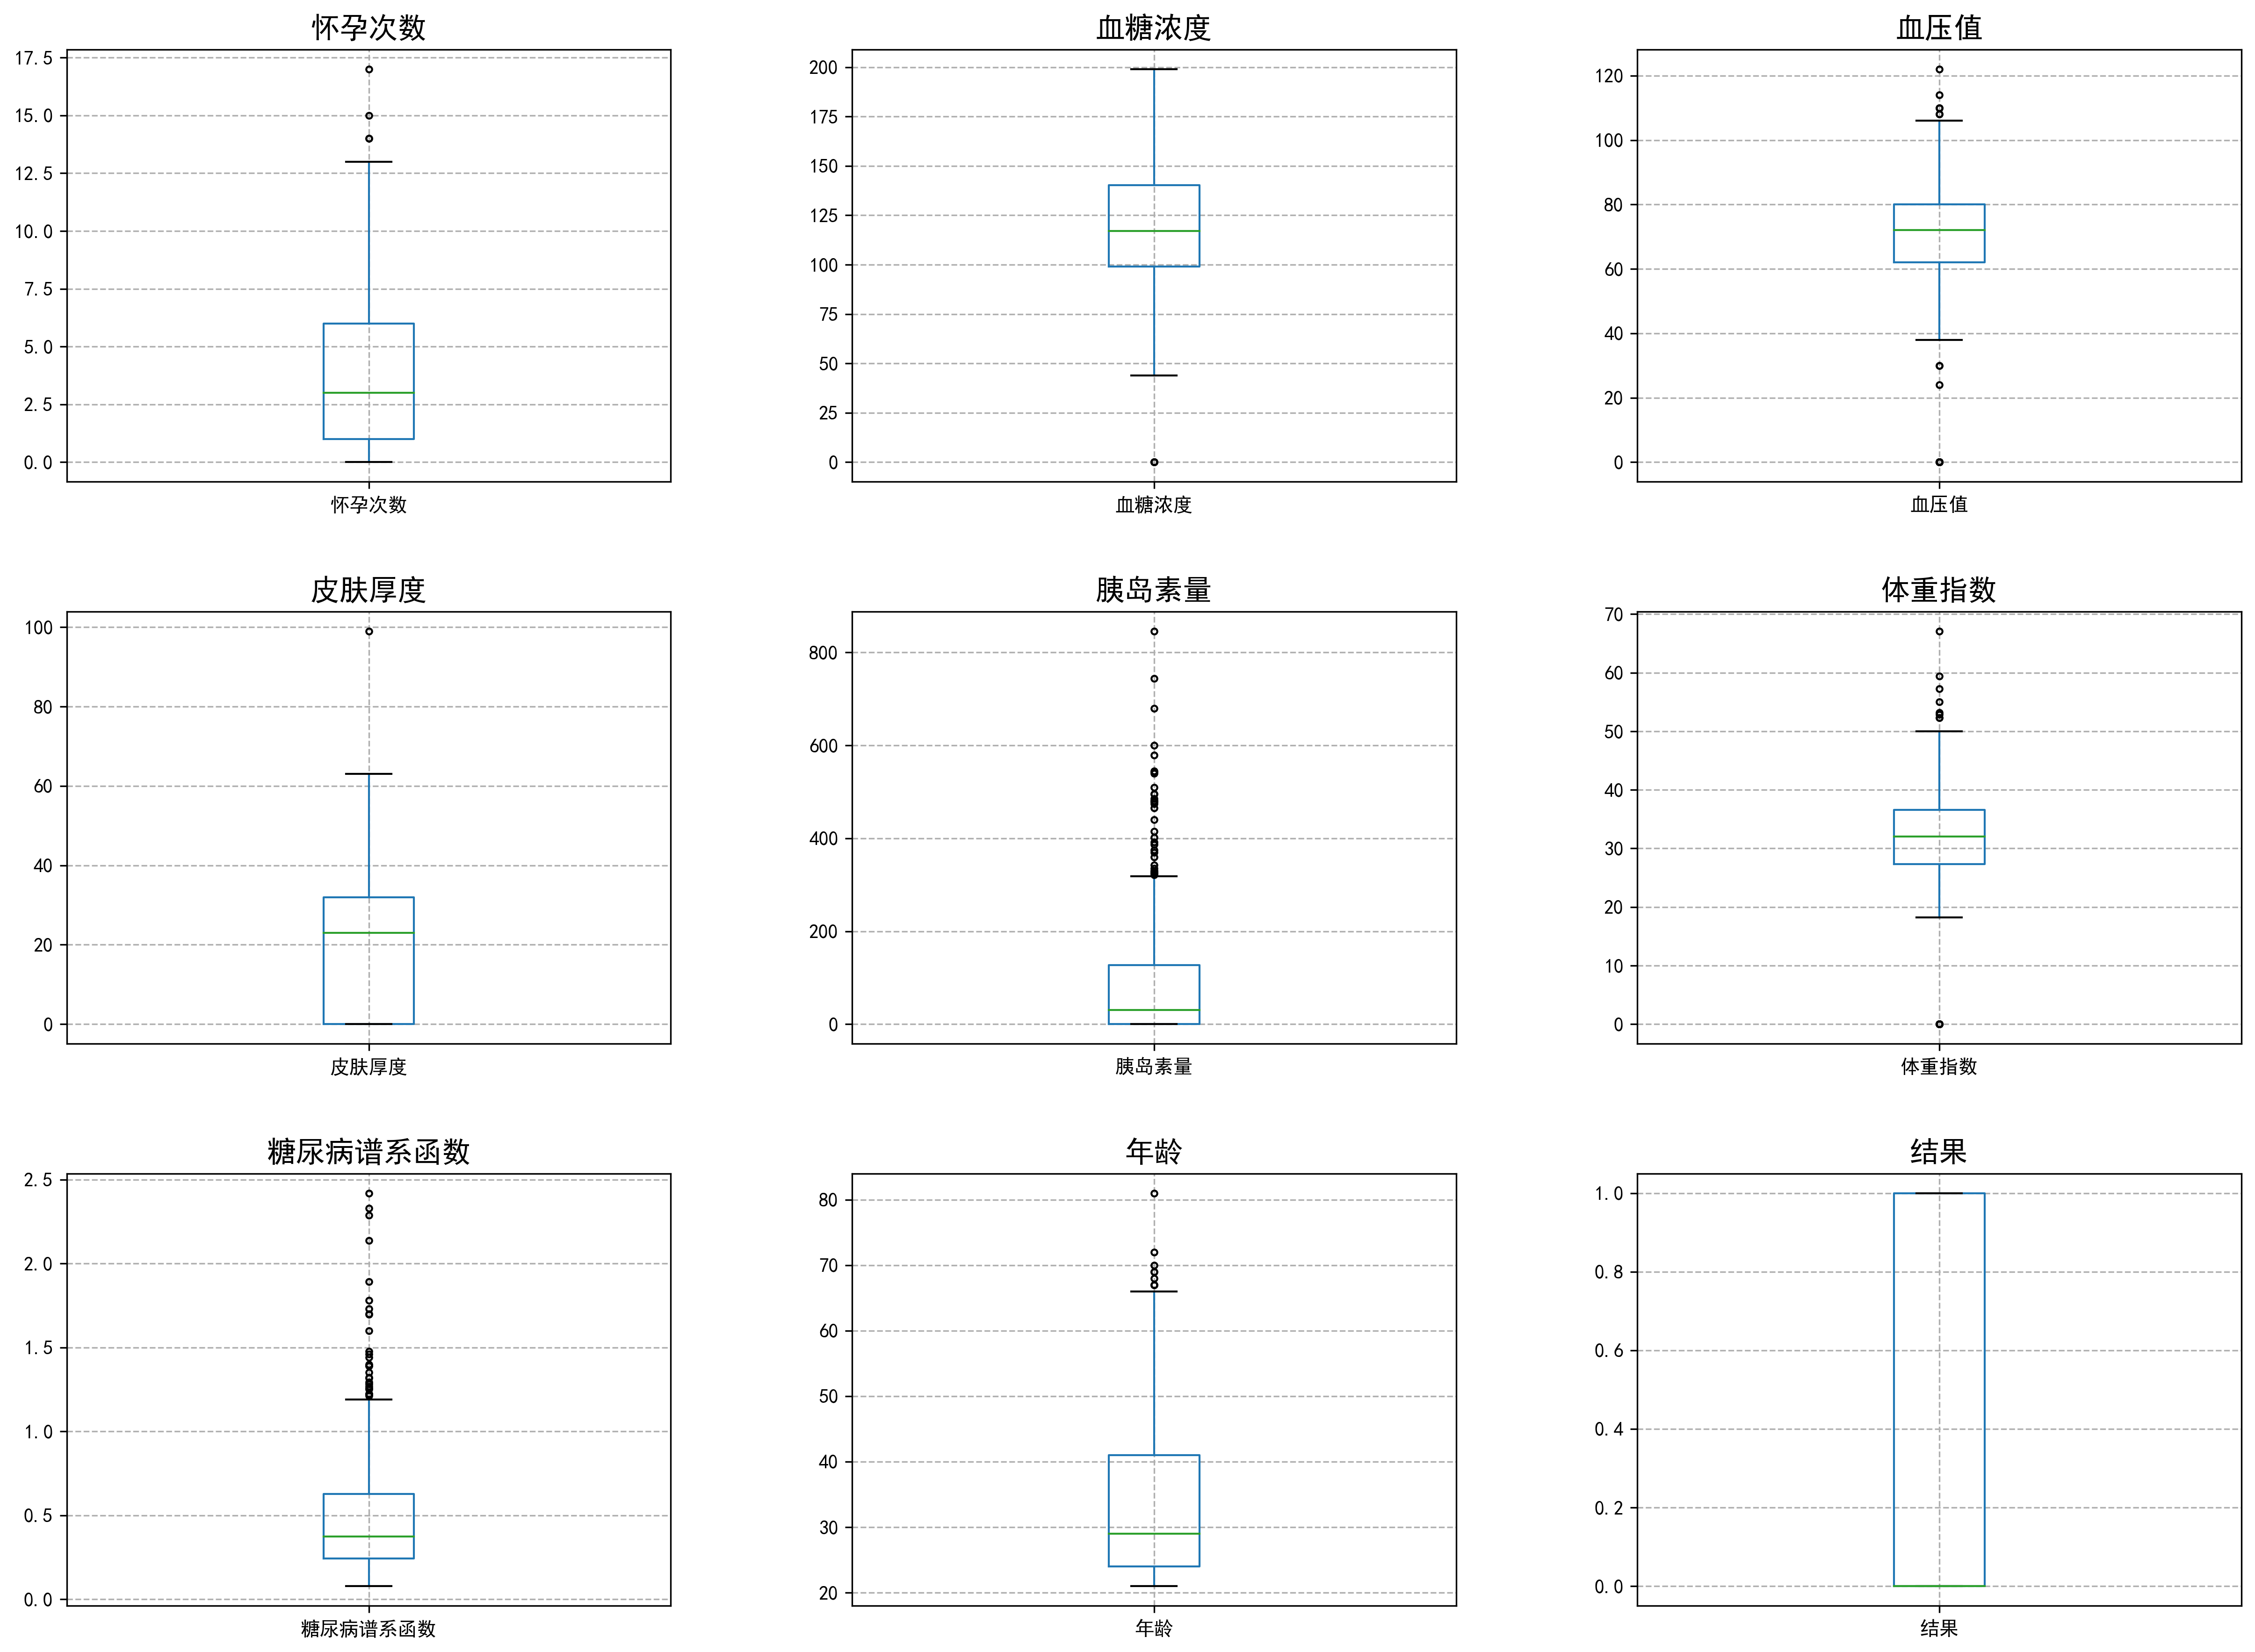

In [5]:
# 通过 箱型图 观察各字段异常情况
# '怀孕次数’正常情况很少大于10次，故可能存在异常值
#  '血压值 '胰岛素量'‘体重指数’，‘糖尿病谱系函数’‘年龄’都存在很多偏离值，难以观察数据分布
plt.rcParams['font.sans-serif']=['SimHei'] #plot色系
plt.figure(figsize=(20,20),dpi=300)
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for n,i in enumerate(train_data.columns):
    plt.subplot(4,3,n+1)
    plt.title(i,fontsize=15)
    plt.grid(linestyle='--')
    train_data[[i]].boxplot(sym='.')

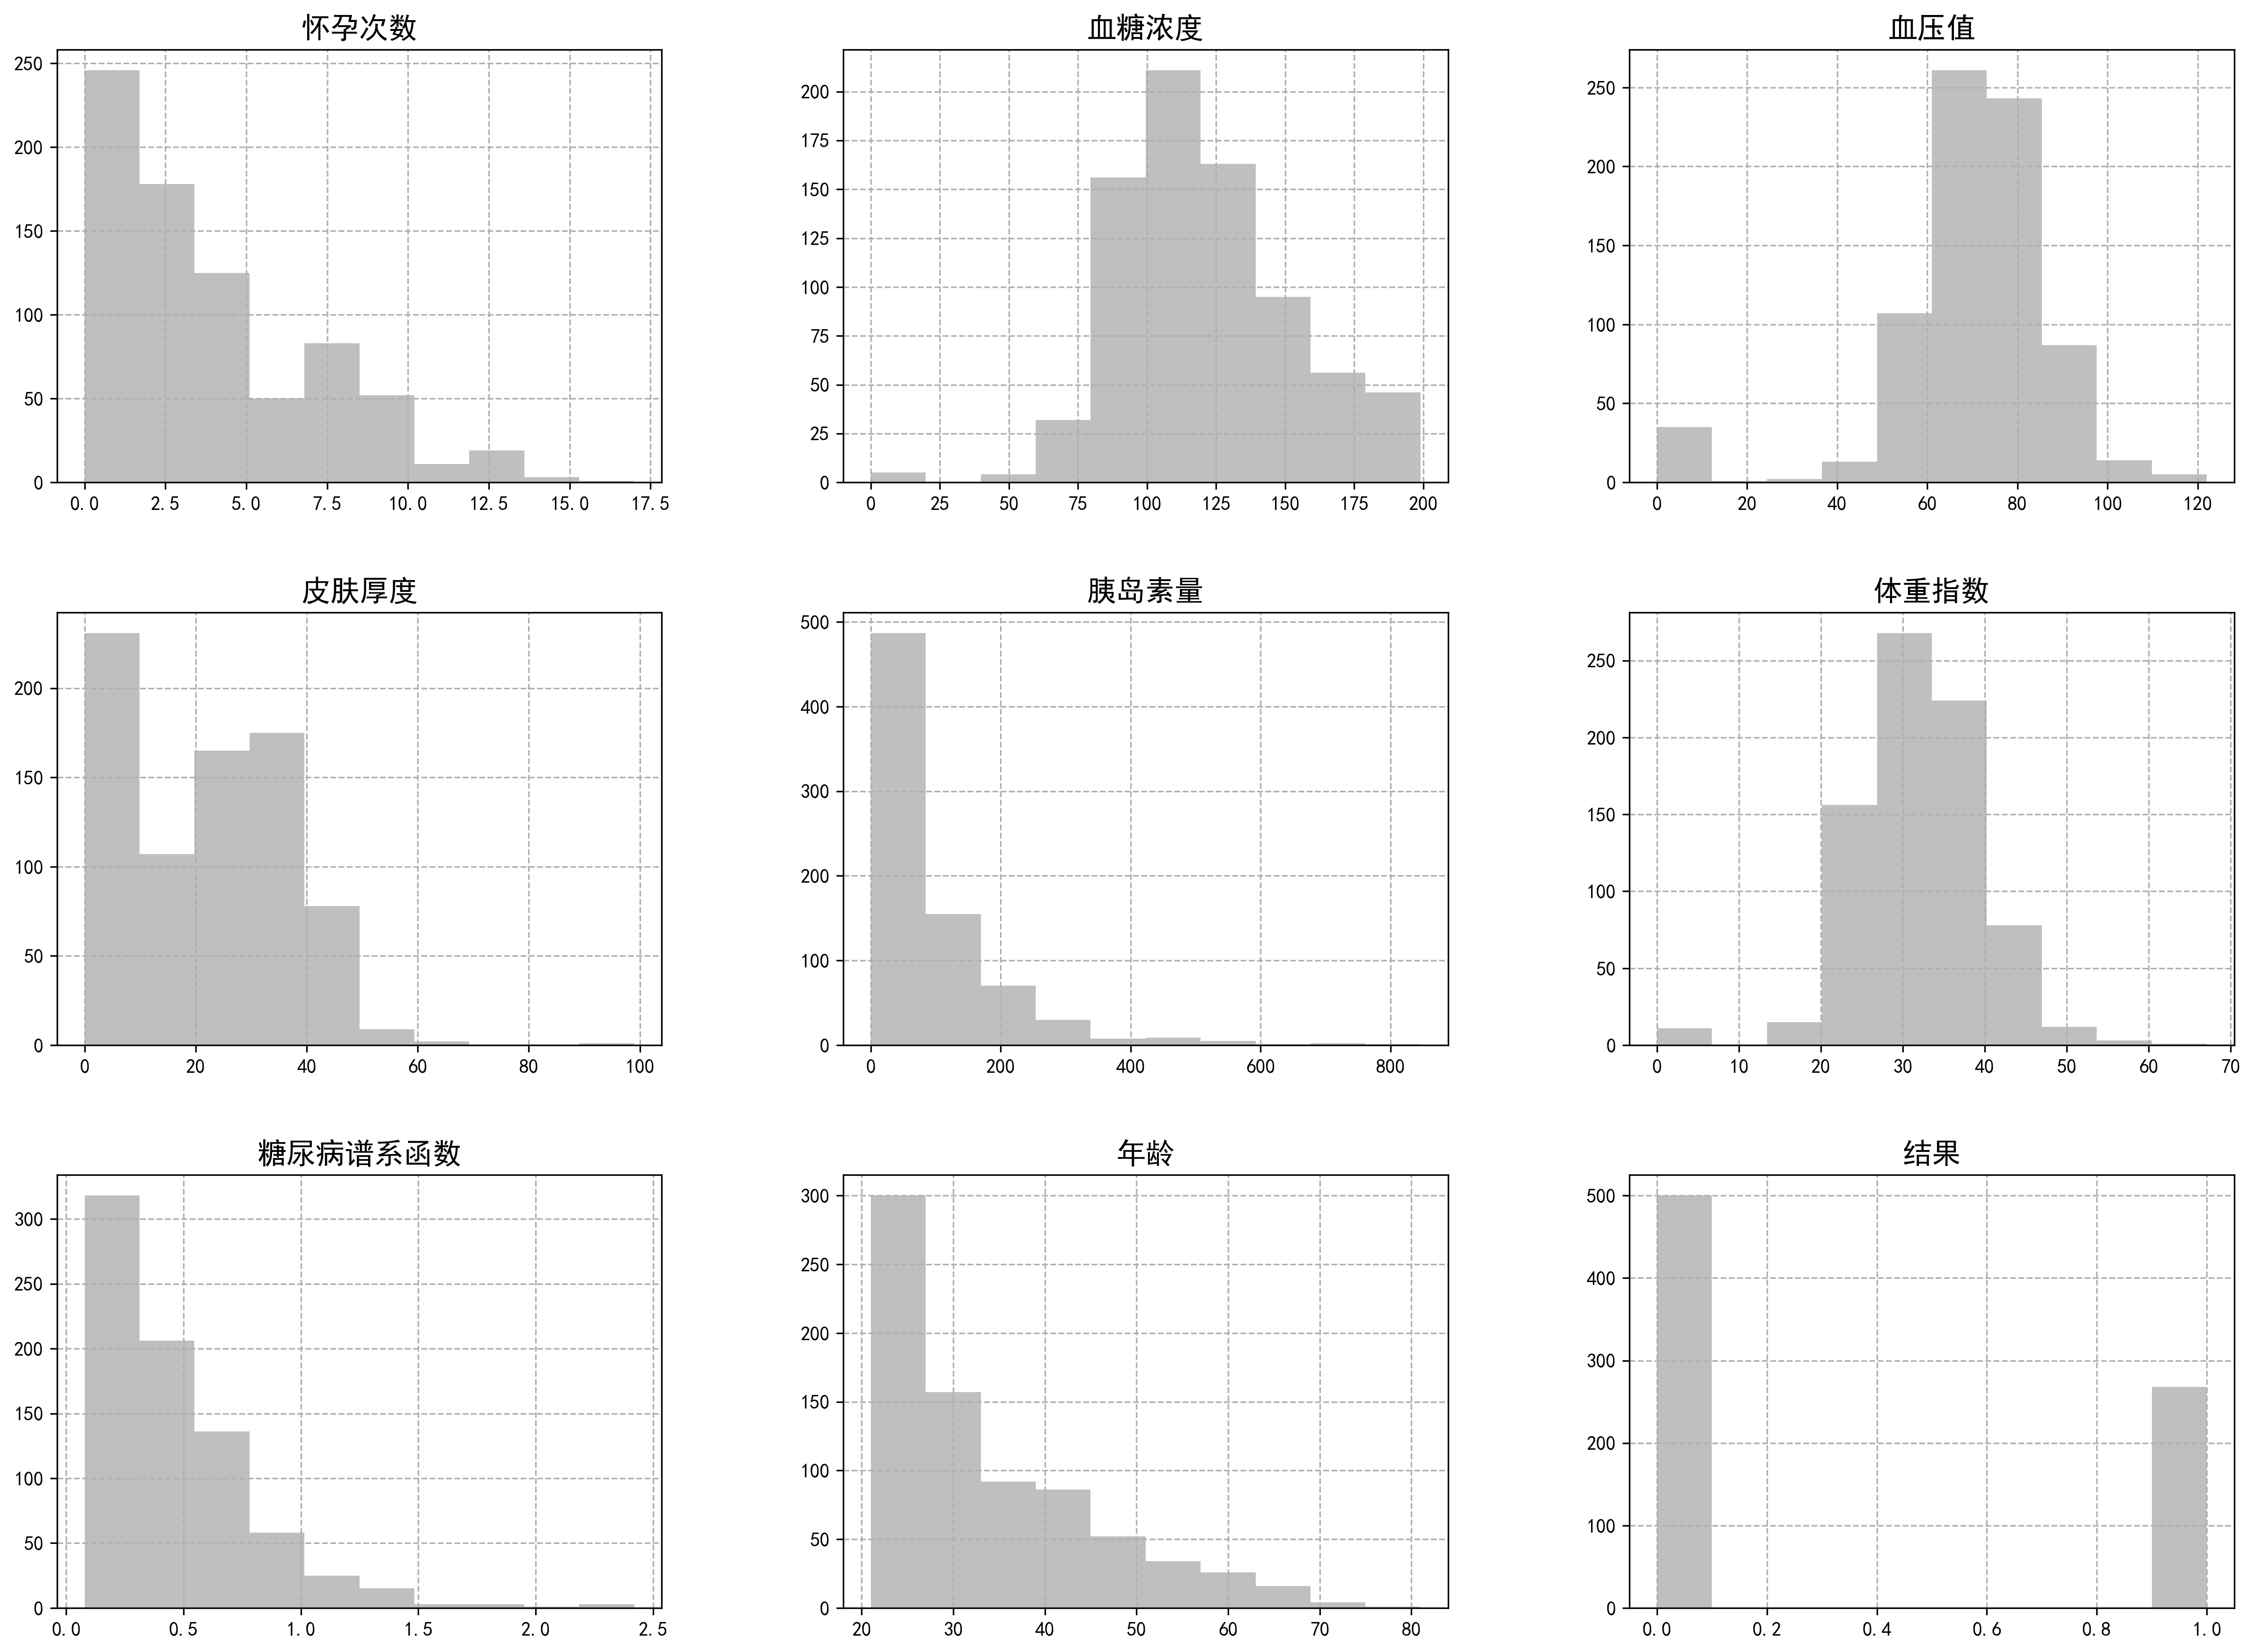

In [6]:
# 输出各字段分布情况图
# 大多数字段明显偏态，后续建模需考虑纠偏处理
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(20,20),dpi=300)
plt.subplots_adjust(wspace =0.3, hspace =0.3)
for n,i in enumerate(train_data.columns):
    plt.subplot(4,3,n+1)
    plt.title(i,fontsize=15)
    plt.grid(linestyle='--')
    train_data[i].hist(color='grey',alpha=0.5)

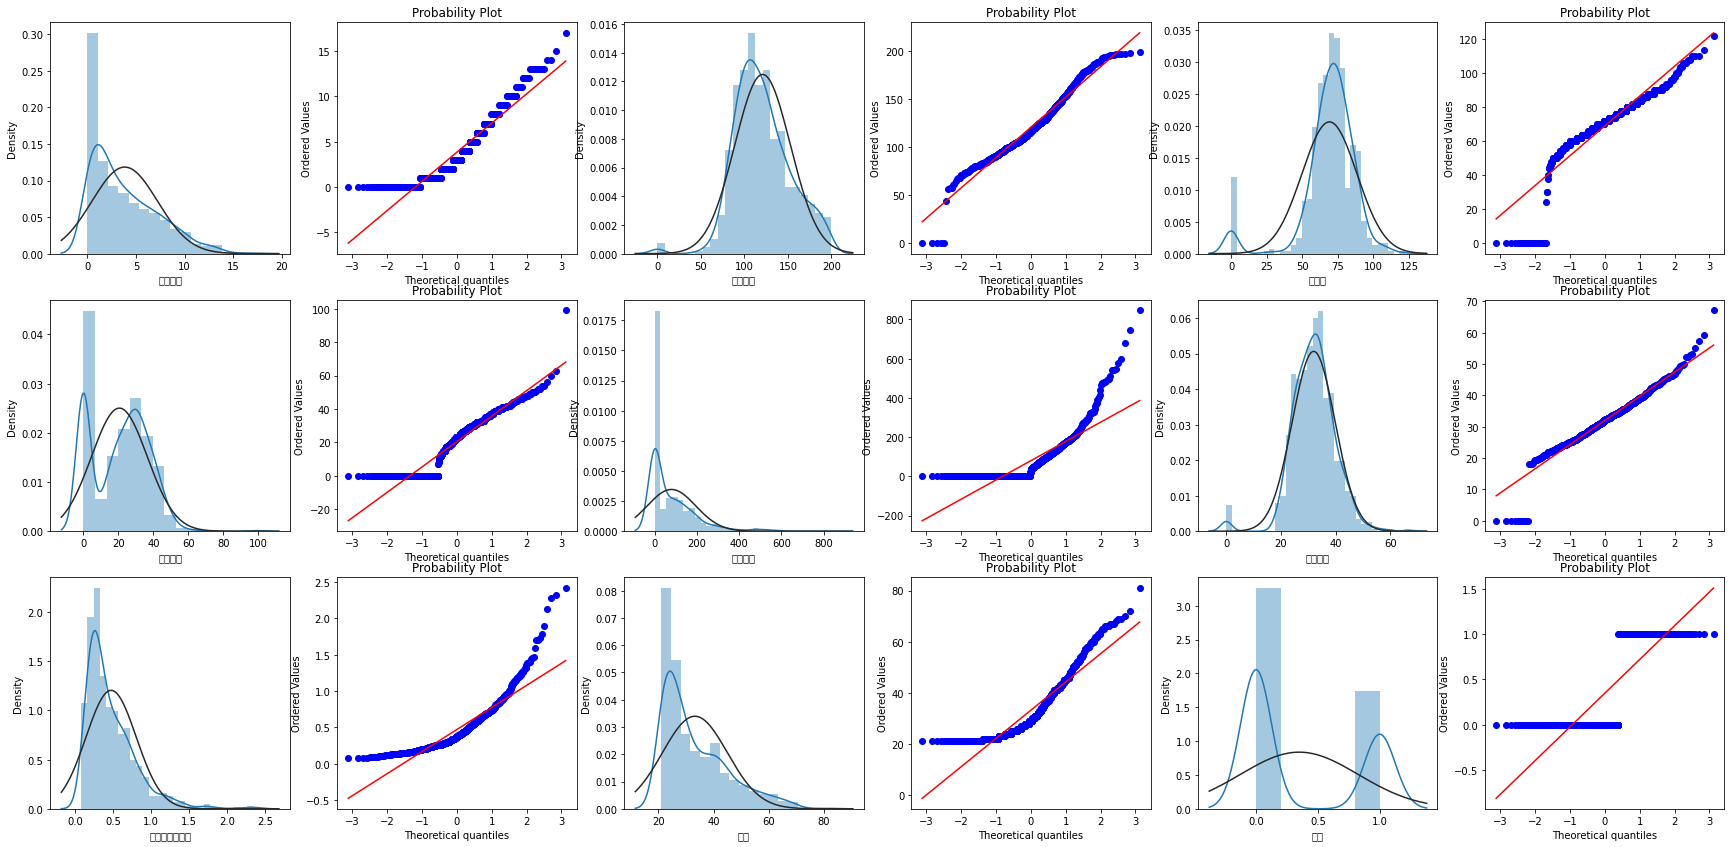

In [6]:
# 查看所有数据的直方图和Q-Q图，查看训练集的数据是否近似于正态分布
#发现‘怀孕次数’‘胰岛素量’‘皮肤厚度’‘糖尿病谱系函数’以及‘年龄’近似程度较差
#‘皮肤厚度’呈现双峰形式

# plt.rcParams['font.sans-serif']=['SimHei'] #前面以及设置过了
train_cols = 6
train_rows = len(train_data.columns)-1
plt.figure(figsize=(5*train_cols,5*train_rows))

i=0
for col in train_data.columns:
    i+=1
    ax=plt.subplot(train_rows,train_cols,i)
    sns.distplot(train_data[col],fit=stats.norm) #用正态分布来拟合 密度分布函数pdf
    
    i+=1
    ax=plt.subplot(train_rows,train_cols,i)
    res = stats.probplot(train_data[col], plot=plt) #CDF
plt.show()

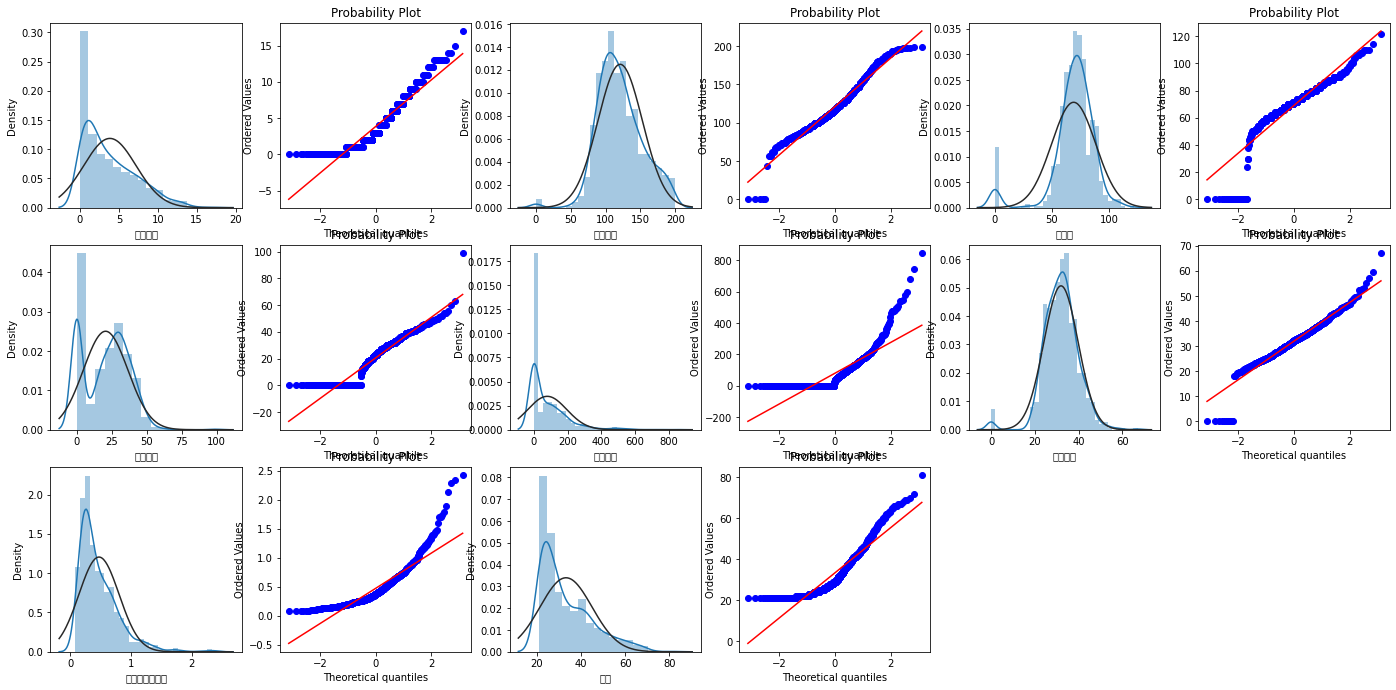

In [9]:
train_cols = 6
train_rows = len(train_data.columns)-1
plt.figure(figsize=(4*train_cols,4*train_rows))

#不打印标签那一个统计
i=0
for col in [col for col in train_data.columns if col not in ['结果']]:
    i+=1
    ax=plt.subplot(train_rows,train_cols,i)
    sns.distplot(train_data[col],fit=stats.norm)
    
    i+=1
    ax=plt.subplot(train_rows,train_cols,i)
    res = stats.probplot(train_data[col], plot=plt)
plt.show()

<AxesSubplot:>

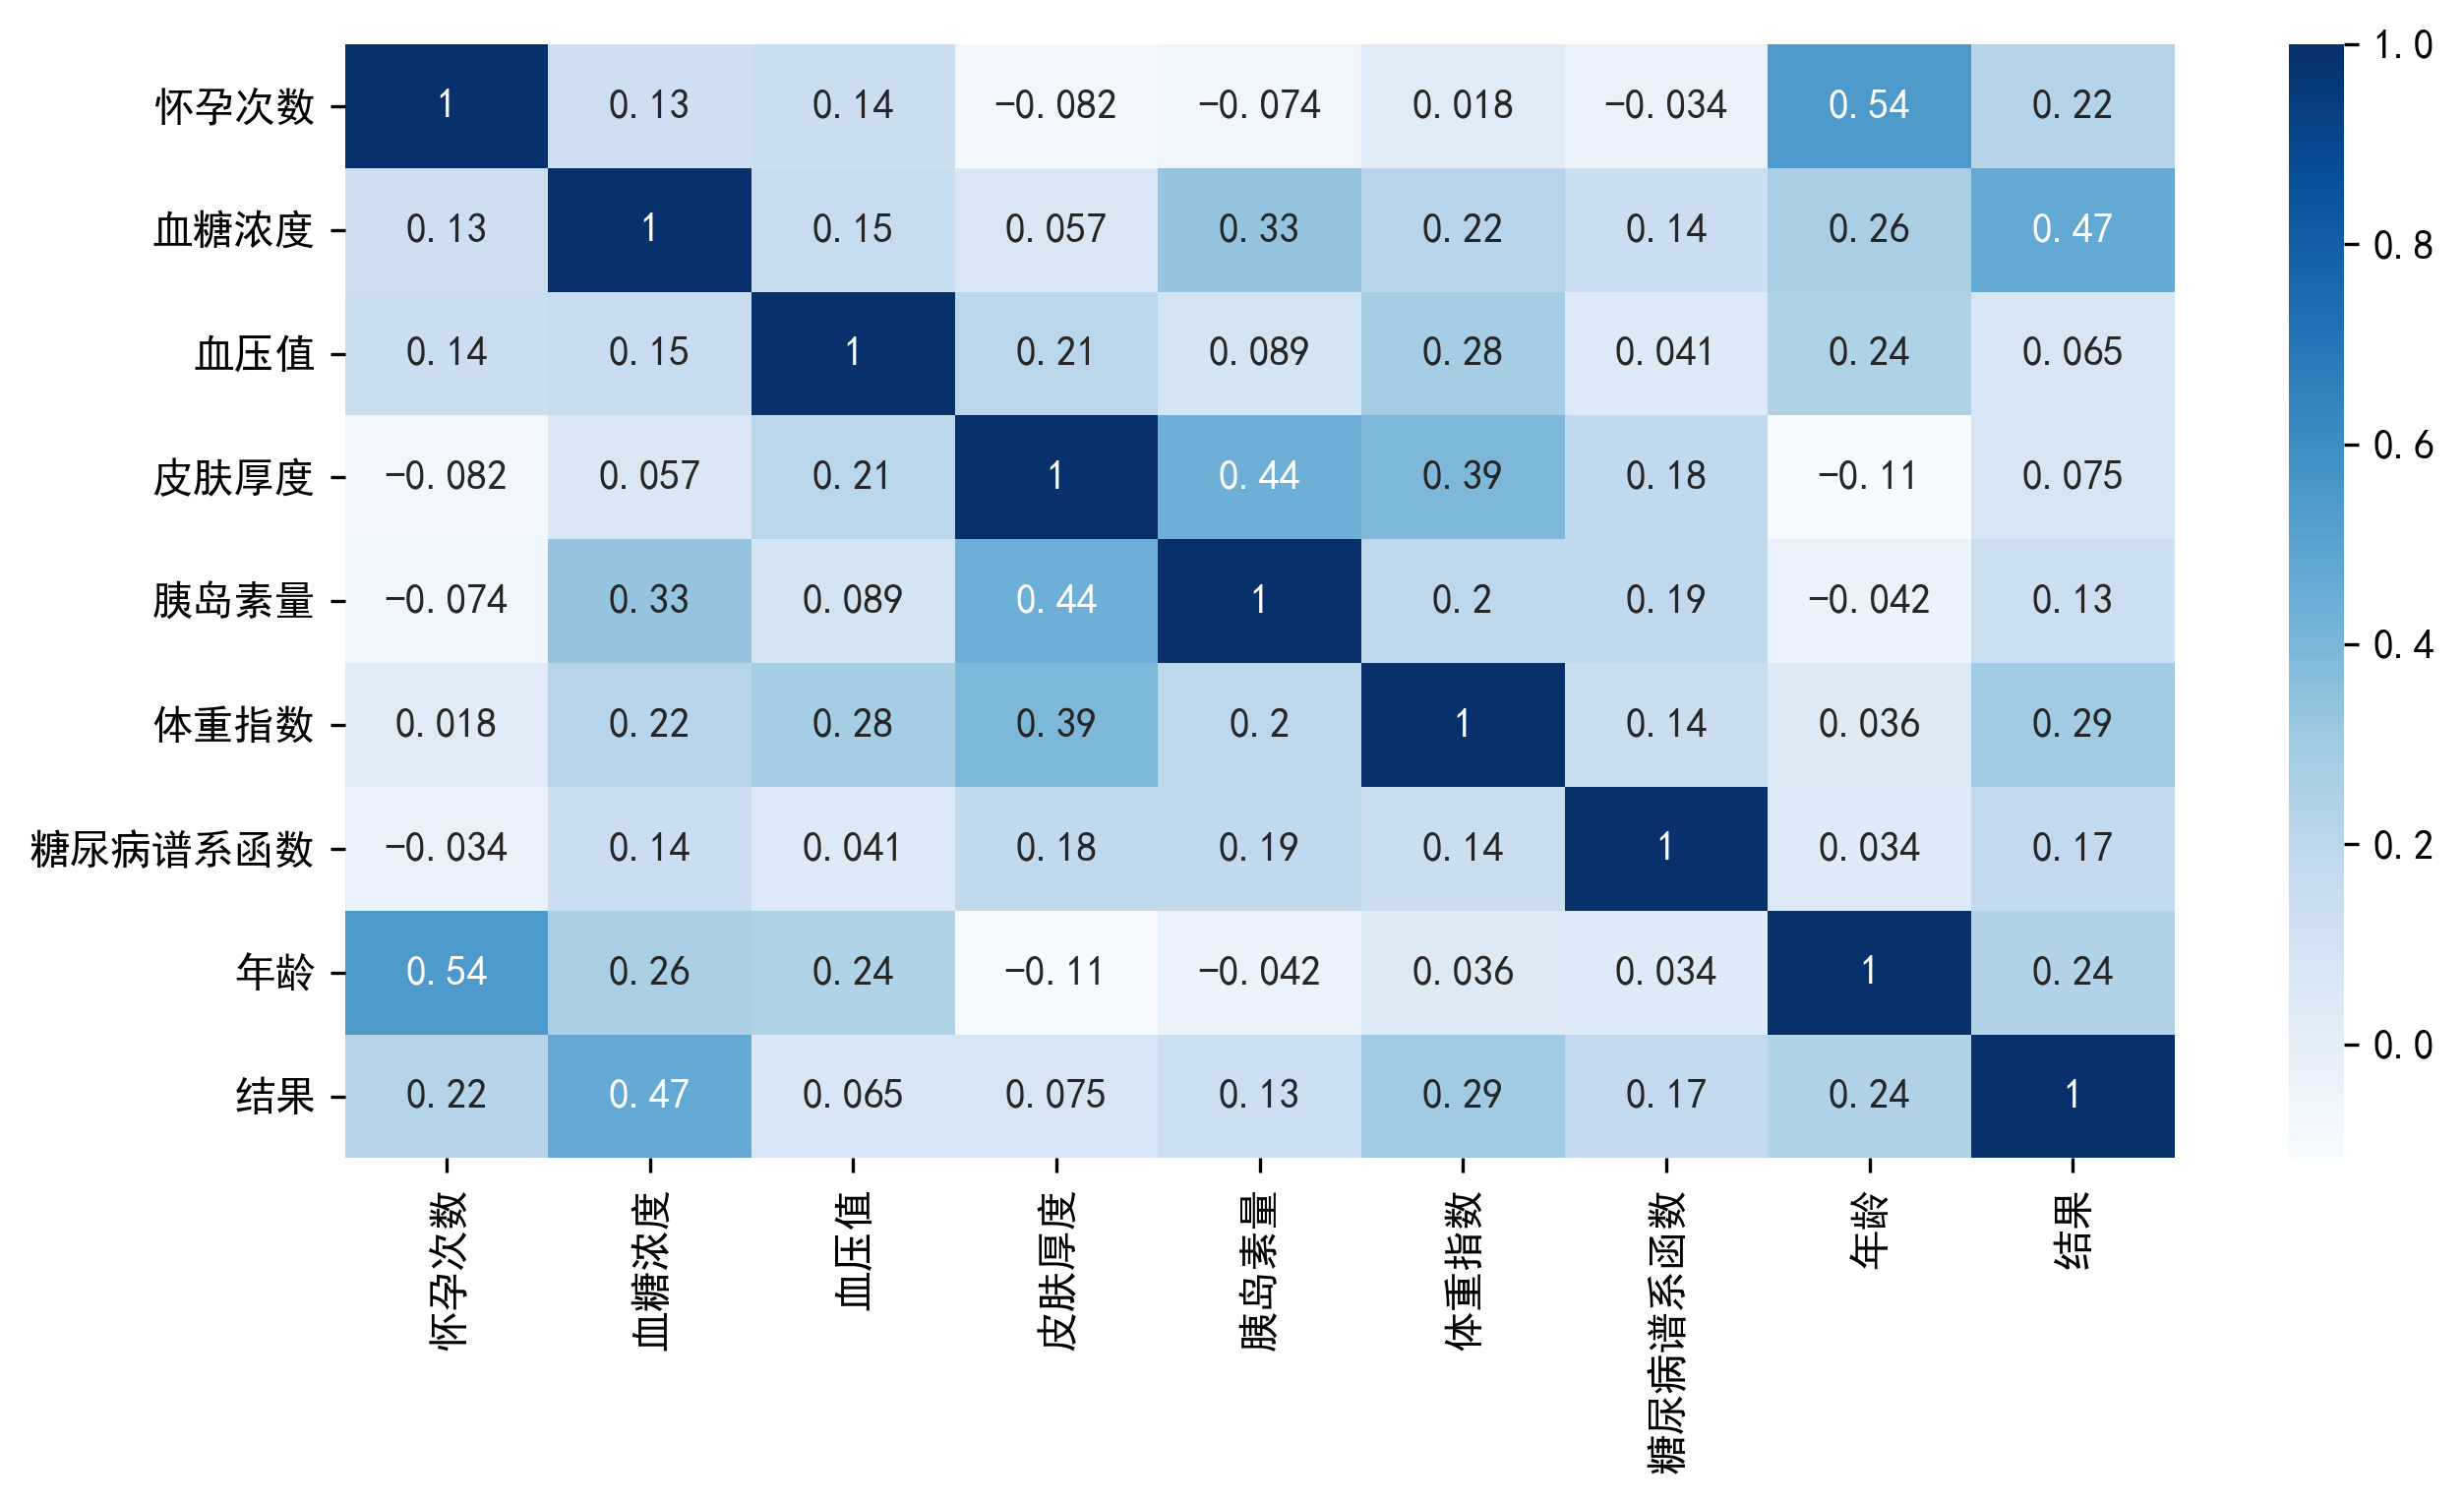

In [8]:
# 由热力图可知，怀孕次数与年龄相关性较强
plt.rcParams['font.sans-serif']=['SimHei']
plt.figure(figsize=(10,5),dpi=300)
sns.heatmap(train_data.corr(),cmap='Blues',annot=True) #也可以Reds

先画图统计分析，再特征工程

In [10]:
def error_processing(data):
    '''
    异常值处理
    data：数据源
    '''
    def show_error(data,col,whis=1.5,is_print=True): #可以更改is_print，True会在后面调用函数的时候打印异常值信息
        '''
        显示异常值数量
        data：数据源
        col：属性名
        whis：默认1.5，对应1.5倍iqr
        is_print：是否显示示例异常数据
        '''
        iqr = data[col].quantile(0.75) - data[col].quantile(0.25)
        upper_bound = data[col].quantile(0.75) + whis * iqr # 上界
        lower_bound = data[col].quantile(0.25) - whis * iqr # 下界
        print('【',col,'】上界异常值总数：',data[col][data[col] > upper_bound].count())
        if is_print:
            print('异常值示例：\n',data[data[col] > upper_bound].head(5).T)
        print('【',col,'】下界异常值总数：',data[col][data[col] < lower_bound].count())
        if is_print:
            print('异常值示例：\n',data[data[col] < lower_bound].head(5).T)
        print('- - - - - - ')
    
    #删除异常值
    # 计数器
    n = len(data)
    
#     # 怀孕次数
#     # 剔除>10的数据
#     show_error(data,'怀孕次数')
#     data = data[data['怀孕次数']<17]

    # 血糖浓度
    # 异常值数量不多，剔除血糖浓度小于50的异常值
    show_error(data,'血糖浓度')
    data = data[data['血糖浓度']>50]

    # 血压值
    # 根据箱型图去除小于40大于120的异常值
    show_error(data,'血压值')
    data = data[(data['血压值']>40)& (data['血压值']<120)]

    # 皮肤厚度
    # 根据箱型图去除>80的异常数据
    show_error(data,'皮肤厚度')
    data = data[data['皮肤厚度']<80]

    # 胰岛素量
    # 根据箱型图去除大于800的异常数据
    show_error(data,'胰岛素量')
    data = data[data['胰岛素量']<800]

    # 体重指数
    # 根据箱型图去除大于50小于20的异常数据
    show_error(data,'体重指数')
    data = data[(data['体重指数']>15)& (data['体重指数']<50)]

    # 糖尿病谱系函数
    # 根据箱型图去除>2.0的异常数据
    show_error(data,'糖尿病谱系函数')
    data = data[data['糖尿病谱系函数']<2.0]

    # 年龄
    # 基本无异常值，剔除年龄大于75的异常数据
    show_error(data,'年龄')
    data = data[data['年龄']<75]

    

    # 删除的异常值数量=信贷数量 - 保留异常值
    print('共删除数据 ',n - len(data),' 条。')
    return data
    


In [11]:
# 从数据初探可以发现，'结果'标签类别分布不均，需对样本进行重取样,以平均样本分布
def resample(data):
    '''
    使样本'结果'标签的0，1项可以各占一半，以提高预测效果。sample()可以考虑添加random_state以便生成相同样本集
    data：数据源
    '''
    num = data['结果'].value_counts()[1]
    data_t = data[data.结果==1]
    data_f = data[data.结果==0].sample(frac=1)[0:num]
    data_balanced = pd.concat([data_t,data_f]).sample(frac=1).reset_index(drop=True)
    print(data_balanced.结果.value_counts())
    return data_balanced

In [12]:
from sklearn import preprocessing 
train_copy = train_data.copy()

# 异常处理
error_processing(train_copy)
# 数据重采样-----------------------------
data_balanced = resample(train_copy)

#归一化处理
features_columns = [col for col in data_balanced.columns if col not in ['结果']]

min_max_scaler = preprocessing.MinMaxScaler()

min_max_scaler = min_max_scaler.fit(data_balanced[features_columns])

train_data_scaler = min_max_scaler.transform(data_balanced[features_columns])


train_data_scaler = pd.DataFrame(train_data_scaler)
train_data_scaler.columns = features_columns

train_data_scaler['结果'] = data_balanced['结果']

train_data_scaler.describe()



【 血糖浓度 】上界异常值总数： 0
异常值示例：
 Empty DataFrame
Columns: []
Index: [怀孕次数, 血糖浓度, 血压值, 皮肤厚度, 胰岛素量, 体重指数, 糖尿病谱系函数, 年龄, 结果]
【 血糖浓度 】下界异常值总数： 5
异常值示例：
            75      182     342     349     502
怀孕次数      1.00   1.000   1.000   5.000   6.000
血糖浓度      0.00   0.000   0.000   0.000   0.000
血压值      48.00  74.000  68.000  80.000  68.000
皮肤厚度     20.00  20.000  35.000  32.000  41.000
胰岛素量      0.00  23.000   0.000   0.000   0.000
体重指数     24.70  27.700  32.000  41.000  39.000
糖尿病谱系函数   0.14   0.299   0.389   0.346   0.727
年龄       22.00  21.000  22.000  37.000  41.000
结果        0.00   0.000   0.000   1.000   1.000
- - - - - - 
【 血压值 】上界异常值总数： 7
异常值示例：
              43       84       106      177      362
怀孕次数       9.000    5.000    1.000    0.000    5.000
血糖浓度     171.000  137.000   96.000  129.000  103.000
血压值      110.000  108.000  122.000  110.000  108.000
皮肤厚度      24.000    0.000    0.000   46.000   37.000
胰岛素量     240.000    0.000    0.000  130.000    0.000
体重指数      45.400   48.800   22.

,怀孕次数,血糖浓度,血压值,皮肤厚度,胰岛素量,体重指数,糖尿病谱系函数,年龄,结果
count,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000,536.000000
mean,0.241879,0.628581,0.608569,0.212423,0.098515,0.484480,0.174943,0.260755,0.500000
std,0.204393,0.167695,0.171061,0.162664,0.142439,0.120380,0.148706,0.234824,0.500467
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.058824,0.506281,0.561404,0.000000,0.000000,0.414307,0.071276,0.073529,0.000000
50%,0.176471,0.608040,0.631579,0.232323,0.036052,0.488823,0.131635,0.176471,0.500000
75%,0.411765,0.738693,0.701754,0.333333,0.154255,0.550298,0.244007,0.411765,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
# 最后将数据集划分成训练集和验证集，两者划分比例都为8：2
X = data_balanced.drop(['结果'],axis=1) 
y = data_balanced['结果']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)   

#随机过采样
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
xtrain, ytrain = ros.fit_resample(xtrain, ytrain)

# # smote重采样方法
# from imblearn.over_sampling import SMOTE 
# xtrain, ytrain = SMOTE().fit_resample(xtrain, ytrain)

# 分层k折交叉拆分器 - 用于网格搜索
cv = StratifiedKFold(n_splits=3,shuffle=True)

In [14]:
# 分类模型性能查看函数
def activity(model,X,y,name=None):
    y_predict = model.predict(X)
    if name:
        print(name,':')
    print(f'accuracy score is: {accuracy_score(y,y_predict)}')
    print(f'precision score is: {precision_score(y,y_predict)}')
    print(f'recall score is: {recall_score(y,y_predict)}')
    print(f'auc: {roc_auc_score(y,y_predict)}')
    print('- - - - - - ')

## 逻辑回归模型

In [15]:
#逻辑回归模型
# 参数设定
logi = {"penalty":['l1','l2'],
                 'C':[0.001*10**i for i in range(0,7)]}
# 参数搜索
logi_search = GridSearchCV(LogisticRegression(solver='liblinear'),logi,cv=cv,
                               n_jobs=-1,scoring='roc_auc',verbose=2,refit=True)
# 工作流管道
road_logi = Pipeline([
        ('sc',StandardScaler()),    # 标准化Z-score
        ('pow_trans',PowerTransformer()),    # 纠偏
        ('logi_grid',logi_search)
        ])
# 搜索参数并训练模型
road_logi.fit(xtrain,ytrain)
# 最佳参数组合
print('最优参数:',road_logi.named_steps['logi_grid'].best_params_)
print('最佳模型参数的评分:',road_logi.named_steps['logi_grid'].best_score_)

# 训练集性能指标
activity(road_logi,xtrain,ytrain,name='train')
# 测试集性能指标
activity(road_logi,xtest,ytest,name='test')

Fitting 3 folds for each of 14 candidates, totalling 42 fits
最优参数: {'C': 0.1, 'penalty': 'l1'}
最佳模型参数的评分: 0.8452696632469715
train :
accuracy score is: 0.7674418604651163
precision score is: 0.7860696517412935
recall score is: 0.7348837209302326
auc: 0.7674418604651163
- - - - - - 
test :
accuracy score is: 0.7129629629629629
precision score is: 0.7037037037037037
recall score is: 0.7169811320754716
auc: 0.7130360205831904
- - - - - - 


In [16]:
# 交叉验证查看平均分数——训练集
cross_val_score(road_logi,xtrain,ytrain,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits


0.8434719686431346

In [17]:
# 交叉验证查看平均分数——测试集
cross_val_score(road_logi,xtest,ytest,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits
Fitting 3 folds for each of 14 candidates, totalling 42 fits


0.7775420759596886

0.000000 0.000000 1.953281
0.000000 0.018868 0.953281
0.000000 0.037736 0.950848
0.018182 0.037736 0.895746
0.018182 0.075472 0.888140
0.036364 0.075472 0.883094
0.036364 0.094340 0.880812
0.054545 0.094340 0.864217
0.054545 0.113208 0.863218
0.072727 0.113208 0.860706
0.072727 0.339623 0.773072
0.109091 0.339623 0.767758
0.109091 0.396226 0.757274
0.145455 0.396226 0.722552
0.145455 0.415094 0.699415
0.200000 0.415094 0.694175
0.200000 0.452830 0.675679
0.218182 0.452830 0.665841
0.218182 0.471698 0.636093
0.236364 0.471698 0.628005
0.236364 0.603774 0.598105
0.254545 0.603774 0.587100
0.254545 0.641509 0.565454
0.272727 0.641509 0.547340
0.272727 0.716981 0.523052
0.290909 0.716981 0.515562
0.290909 0.754717 0.483645
0.327273 0.754717 0.476315
0.327273 0.773585 0.471101
0.345455 0.773585 0.464516
0.345455 0.905660 0.412887
0.363636 0.905660 0.409110
0.363636 0.924528 0.399441
0.436364 0.924528 0.361340
0.436364 0.962264 0.350047
0.600000 0.962264 0.271241
0.600000 0.981132 0.265322
0

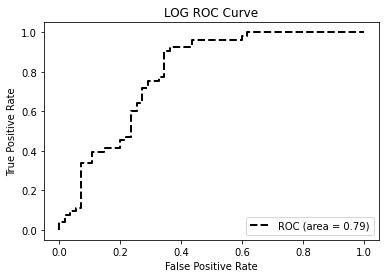

In [18]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 
ytest1=ytest.tolist()
ytestss = [2 if i == 1 else i for i in ytest1]
y_test = [1 if i == 0 else i for i in ytestss]
result = road_logi.predict_proba(xtest)
result_ = [[n,i] for n,i in enumerate(result[:,1])]
data_result = pd.DataFrame(result_,columns=['uid','Probability'])
y_predict = data_result['Probability'].tolist()

fpr, tpr, thersholds = roc_curve(y_test, y_predict, pos_label=2)
 
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))
 
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('LOG ROC Curve')
plt.legend(loc="lower right")
plt.show()

## XGBoost 模型

In [19]:
# xgboost模型
xgb_clf = xgb.XGBClassifier(objective='binary:logistic',
                            n_job=-1,
                            booster='gbtree',
                            n_estimators=1000,
                            learning_rate=0.01)
# 参数设定
xgb_params = {'max_depth':[6,9],    # 注意参数设置，数量多了会更加耗时
             'subsample':[0.6,0.9],
             'colsample_bytree':[0.5,0.6],
             'reg_alpha':[0.05,0.1]}
# 参数搜索
xgb_gridsearch = GridSearchCV(xgb_clf,xgb_params,cv=cv,n_jobs=-1,
                                 scoring='roc_auc',verbose=10,refit=True)
# 工作流管道
pipe_xgb = Pipeline([
    ('sc',StandardScaler()),
    ('pow_trans',PowerTransformer()),
    ('xgb_grid',xgb_gridsearch)
])
# 搜索参数并训练模型
pipe_xgb.fit(xtrain,ytrain)
# 最佳参数组合
print('最优参数:',pipe_xgb.named_steps['xgb_grid'].best_params_)
print('最佳模型参数的评分:',pipe_xgb.named_steps['xgb_grid'].best_score_)

# 训练集性能指标
activity(pipe_xgb,xtrain,ytrain,name='train')
# 测试集性能指标
activity(pipe_xgb,xtest,ytest,name='test')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[10:18:30] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_job" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


最优参数: {'colsample_bytree': 0.5, 'max_depth': 9, 'reg_alpha': 0.1, 'subsample': 0.6}
最佳模型参数的评分: 0.8266578638497654
train :
accuracy score is: 0.9930232558139535
precision score is: 0.9953271028037384
recall score is: 0.9906976744186047
auc: 0.9930232558139536
- - - - - - 
test :
accuracy score is: 0.7314814814814815
precision score is: 0.6818181818181818
recall score is: 0.8490566037735849
auc: 0.7336192109777016
- - - - - - 


In [21]:
# 交叉验证查看平均分数——训练集
cross_val_score(pipe_xgb,xtrain,ytrain,cv=3,scoring='roc_auc').mean()


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[10:19:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_job" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting 3 folds for each of 16 candidates, totalling 48 fits
[10:19:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "n_job" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


Fitting 3 folds for each of 16 candidates, totalli

0.8446465832029212

In [ ]:
# auc——测试集
cross_val_score(pipe_xgb,xtest,ytest,cv=3,scoring='roc_auc').mean()

In [ ]:
#ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 
ytest1=ytest.tolist()
ytestss = [2 if i == 1 else i for i in ytest1]
y_test = [1 if i == 0 else i for i in ytestss]
result = pipe_xgb.predict_proba(xtest)
result_ = [[n,i] for n,i in enumerate(result[:,1])]
data_result = pd.DataFrame(result_,columns=['uid','Probability'])
y_predict = data_result['Probability'].tolist()

fpr, tpr, thersholds = roc_curve(y_test, y_predict, pos_label=2)
 
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))
 
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('XGB ROC Curve')
plt.legend(loc="lower right")
plt.show()

Index(['怀孕次数', '血糖浓度', '血压值', '皮肤厚度', '胰岛素量', '体重指数', '糖尿病谱系函数', '年龄'], dtype='object')

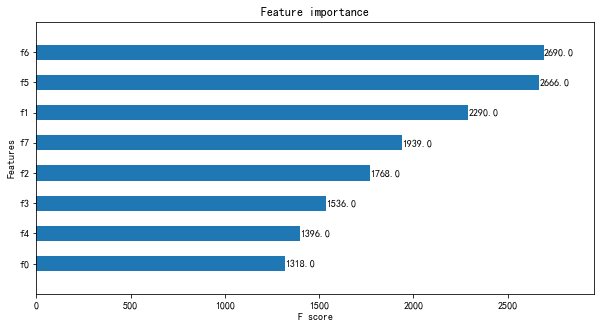

In [18]:
#解释性分析
# 查看字段相对xgboost模型的重要程度
# 显示 ['怀孕次数', '血糖浓度'] 这些字段比较重要
plt.figure(figsize=(10,5))
ax = plt.subplot(1,1,1)
xgb.plot_importance(pipe_xgb.named_steps['xgb_grid'].best_estimator_,
                       max_num_features=40,height=0.5,grid=False,ax=ax)
xtrain.columns

## 随机森林模型

In [23]:
# 随机森林分类模型
rf_clf = RandomForestClassifier(criterion='gini',
                               n_jobs=-1,
                               n_estimators=1000)    
# 参数设定
rf_grid_params = {'max_features':['auto'],    
                    'max_depth':[6,9]}   
# 参数搜索
rf_gridsearch = GridSearchCV(rf_clf,rf_grid_params,cv=cv,
                               n_jobs=-1,scoring='roc_auc',verbose=10,refit=True)
# 工作流管道
pipe_rf = Pipeline([
        ('sc',StandardScaler()),
        ('pow_trans',PowerTransformer()),
        ('rf_grid',rf_gridsearch)
        ])
# 搜索参数并训练模型
pipe_rf.fit(xtrain,ytrain)
# 最佳参数组合
print(pipe_rf.named_steps['rf_grid'].best_params_)
# 训练集性能指标
activity(pipe_rf,xtrain,ytrain,name='train')
# 测试集性能指标
activity(pipe_rf,xtest,ytest,name='test')

Fitting 3 folds for each of 2 candidates, totalling 6 fits
{'max_depth': 6, 'max_features': 'auto'}
train :
accuracy score is: 0.9232558139534883
precision score is: 0.9136363636363637
recall score is: 0.9348837209302325
auc: 0.9232558139534883
- - - - - - 
test :
accuracy score is: 0.75
precision score is: 0.7166666666666667
recall score is: 0.8113207547169812
auc: 0.751114922813036
- - - - - - 


In [24]:
# 查看模型网格搜索调参后的参数
rf_clf = RandomForestClassifier(criterion='gini',
                               n_jobs=-1,
                               n_estimators=1000,
                               max_features='auto',    
                                max_depth=6)
rf_clf.fit(xtrain,ytrain)

RandomForestClassifier(max_depth=6, max_features='auto', n_estimators=1000,
                       n_jobs=-1)

In [25]:
# 交叉验证查看平均分数——训练集
cross_val_score(pipe_rf,xtrain,ytrain,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Fitting 3 folds for each of 2 candidates, totalling 6 fits


0.8341774006548688

In [ ]:
# 测试集
cross_val_score(pipe_rf,xtest,ytest,cv=3,scoring='roc_auc').mean()

In [ ]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 
ytest1=ytest.tolist()
ytestss = [2 if i == 1 else i for i in ytest1]
y_test = [1 if i == 0 else i for i in ytestss]
result = pipe_rf.predict_proba(xtest)
result_ = [[n,i] for n,i in enumerate(result[:,1])]
data_result = pd.DataFrame(result_,columns=['uid','Probability'])
y_predict = data_result['Probability'].tolist()

fpr, tpr, thersholds = roc_curve(y_test, y_predict, pos_label=2)
 
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))
 
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('RF ROC Curve')
plt.legend(loc="lower right")
plt.show()

### 模型解释性分析——以随机森林模型为例

重要性图-全特征解释 


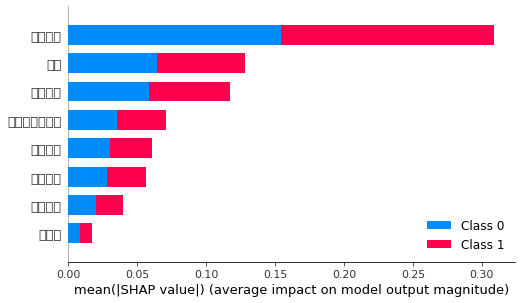

In [26]:
# 导入SHAP库
import shap

# 在笔记本上加载JS可视化代码
shap.initjs()

# 创建一个explainer
explainer = shap.TreeExplainer(rf_clf)

"""
计算所有X_test的shap_values，用于绘制更多数据。 
"""
shap_values = explainer.shap_values(xtest)
     
print("重要性图-全特征解释 ")
figure = plt.figure()
shap.summary_plot(shap_values, xtest)


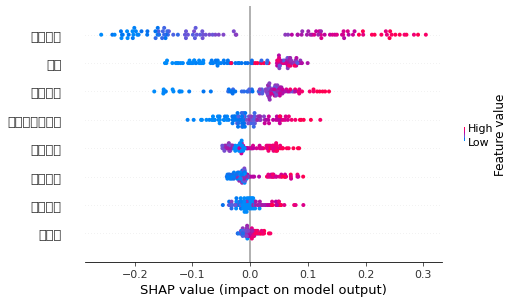

In [27]:
# 标签1上的深度总结
shap.summary_plot(shap_values[1], xtest)

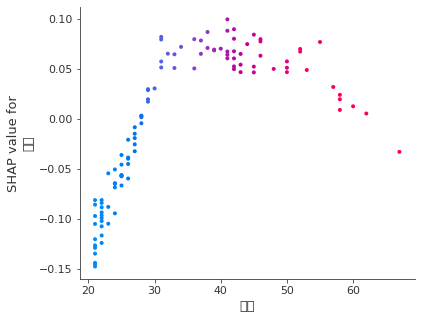

In [28]:
# 年龄相关性图
shap.dependence_plot('年龄', shap_values[1], xtest, interaction_index="年龄")


In [29]:
# 单个病例分析
# 导入LimeTabularExplainer模块
from lime.lime_tabular import LimeTabularExplainer

# 获取类名
class_names = ['得病', '没有得病']

# 获取特征名称
feature_names = list(xtrain.columns)

# 使用LimeTabularExplainer将解释程序放入训练数据集 
explainer = LimeTabularExplainer(xtrain.values, feature_names = feature_names, 
                                 class_names = class_names, mode = 'classification')


In [30]:
#对测试数据中的第12个实例进行说明
explaination = explainer.explain_instance(xtest.iloc[12], rf_clf.predict_proba)

# 展示模型的解释结果
explaination.show_in_notebook(show_table = True, show_all = False)


## SVC模型

In [32]:
# 支持向量机模型
import sklearn
from sklearn.svm import SVC
svm_clf = sklearn.svm.SVC(probability=True) 
# 参数设定
svm_grid_params = {'kernel':('linear','rbf'),
              'C':[1,2,3,4,5,6,7,8,9,10],
              'gamma':[0.01,0.02,0.03,0.04,0.05,0.1,0.2,0.3,0.4,0.5]}
# 参数搜索
svm_gridsearch = GridSearchCV(svm_clf,svm_grid_params,cv=cv,
                               n_jobs=-1,scoring='roc_auc',verbose=10,refit=True)
# 工作流管道
pipe_svm = Pipeline([
        ('sc',StandardScaler()),
        ('pow_trans',PowerTransformer()),
        ('svm_grid',svm_gridsearch)
        ])
# 搜索参数并训练模型
pipe_svm.fit(xtrain,ytrain)
# 最佳参数组合
print('最优参数:',pipe_svm.named_steps['svm_grid'].best_params_)
print('最佳模型参数的评分:',pipe_svm.named_steps['svm_grid'].best_score_)

# 训练集性能指标
activity(pipe_svm,xtrain,ytrain,name='train')
# 测试集性能指标
activity(pipe_svm,xtest,ytest,name='test')

Fitting 3 folds for each of 200 candidates, totalling 600 fits
最优参数: {'C': 3, 'gamma': 0.1, 'kernel': 'rbf'}
最佳模型参数的评分: 0.8558493450414421
train :
accuracy score is: 0.872093023255814
precision score is: 0.8571428571428571
recall score is: 0.8930232558139535
auc: 0.872093023255814
- - - - - - 
test :
accuracy score is: 0.7407407407407407
precision score is: 0.7358490566037735
recall score is: 0.7358490566037735
auc: 0.7406518010291595
- - - - - - 


In [22]:
# 交叉验证查看平均分数——训练集
cross_val_score(pipe_svm,xtrain,ytrain,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits


0.8257841257246138

In [33]:
# 交叉验证查看平均分数——测试集
cross_val_score(pipe_svm,xtest,ytest,cv=3,scoring='roc_auc').mean()

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits
Fitting 3 folds for each of 200 candidates, totalling 600 fits


0.7878460676018295

0.000000 0.000000 1.940287
0.000000 0.018868 0.940287
0.000000 0.056604 0.917516
0.018182 0.056604 0.885203
0.018182 0.075472 0.880520
0.036364 0.075472 0.878762
0.036364 0.113208 0.878344
0.072727 0.113208 0.865192
0.072727 0.226415 0.851304
0.090909 0.226415 0.850447
0.090909 0.283019 0.834587
0.127273 0.283019 0.821566
0.127273 0.358491 0.808334
0.163636 0.358491 0.805383
0.163636 0.396226 0.794907
0.181818 0.396226 0.794159
0.181818 0.452830 0.764002
0.200000 0.452830 0.757185
0.200000 0.547170 0.716095
0.218182 0.547170 0.698014
0.218182 0.660377 0.633866
0.254545 0.660377 0.567839
0.254545 0.735849 0.517338
0.272727 0.735849 0.487205
0.272727 0.754717 0.471717
0.327273 0.754717 0.437832
0.327273 0.773585 0.435603
0.345455 0.773585 0.432507
0.345455 0.830189 0.399831
0.363636 0.830189 0.395403
0.363636 0.886792 0.376292
0.400000 0.886792 0.343065
0.400000 0.943396 0.305776
0.490909 0.943396 0.242617
0.490909 0.962264 0.225845
0.509091 0.962264 0.220972
0.509091 0.981132 0.207587
0

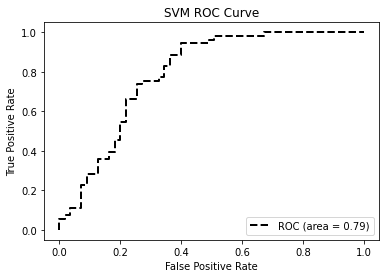

In [34]:
# ROC
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
 
ytest1=ytest.tolist()
ytestss = [2 if i == 1 else i for i in ytest1]
y_test = [1 if i == 0 else i for i in ytestss]
result = pipe_svm.predict_proba(xtest)
result_ = [[n,i] for n,i in enumerate(result[:,1])]
data_result = pd.DataFrame(result_,columns=['uid','Probability'])
y_predict = data_result['Probability'].tolist()

fpr, tpr, thersholds = roc_curve(y_test, y_predict, pos_label=2)
 
for i, value in enumerate(thersholds):
    print("%f %f %f" % (fpr[i], tpr[i], value))
 
roc_auc = auc(fpr, tpr)
 
plt.plot(fpr, tpr, 'k--', label='ROC (area = {0:.2f})'.format(roc_auc), lw=2)
 
plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好的观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')  # 可以使用中文，但需要导入一些库即字体
plt.title('SVM ROC Curve')
plt.legend(loc="lower right")
plt.show()

## 神经网络

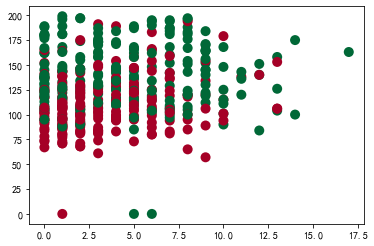

accuracy score is: 0.6939252336448598
precision score is: 0.8454106280193237
recall score is: 0.6386861313868614
auc: 0.7154469617973267
- - - - - - 


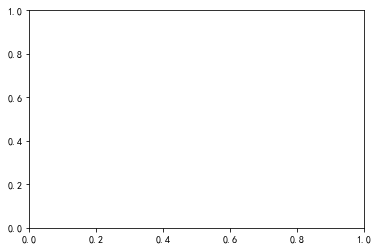

In [68]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F   # 激励函数都在这

# 最后将数据集划分成训练集和验证集，两者划分比例都为8：2
X = data_balanced.drop(['结果'],axis=1) 
y = data_balanced['结果']
xtrain,xtest,ytrain,ytest = train_test_split(X,y,test_size=0.2)  
         
xtrain=torch.from_numpy(xtrain.values)
ytrain=torch.from_numpy(ytrain.values)
plt.scatter(xtrain.data.numpy()[:, 0], xtrain.data.numpy()[:, 1], c=ytrain.data.numpy(), s=100, lw=0, cmap='RdYlGn')
plt.show()


# 建立神经网络
class Net(torch.nn.Module):     # 继承 torch 的 Module
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()     # 继承 __init__ 功能
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # 隐藏层线性输出
        self.out = torch.nn.Linear(n_hidden, n_output)       # 输出层线性输出

    def forward(self, x):
        # 正向传播输入值, 神经网络分析出输出值
        x=x.float()
        x = F.relu(self.hidden(x))      # 激励函数(隐藏层的线性值)
        x = self.out(x)                 # 输出值, 但是这个不是预测值, 预测值还需要再另外计算
        return x

net = Net(n_feature=8, n_hidden=428, n_output=2) # 几个类别就几个 output


# 训练网络
optimizer = torch.optim.SGD(net.parameters(), lr=0.02)  
# 算误差的时候, 注意真实值!不是! one-hot 形式的, 而是1D Tensor, (batch,)
# 但是预测值是2D tensor (batch, n_classes)
loss_func = torch.nn.CrossEntropyLoss()

# plt.ion()   # 画图
# plt.show()

for t in range(100):
    out = net(xtrain)     # 喂给 net 训练数据 x, 输出分析值

    loss = loss_func(out, ytrain)     # 计算两者的误差

    optimizer.zero_grad()   
    loss.backward()         
    optimizer.step()        

    # 可视化展示
    if t % 2 == 0:
        plt.cla()
        # 过了一道 softmax 的激励函数后的最大概率才是预测值
        prediction = torch.max(F.softmax(out), 1)[1]

        pred_y = prediction.data.numpy().squeeze()
        target_y = ytrain.data.numpy()
        # plt.scatter(xtrain.data.numpy()[:, 0], xtrain.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
        accuracy = sum(pred_y == target_y) / 484.  # 计算准确度
        # plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color': 'red'})
        # plt.pause(0.1)
print(f'accuracy score is: {accuracy_score(pred_y,target_y)}')
print(f'precision score is: {precision_score(pred_y,target_y)}')
print(f'recall score is: {recall_score(pred_y,target_y)}')
print(f'auc: {roc_auc_score(pred_y,target_y)}')
print('- - - - - - ')

# plt.ioff()  # 停止画图
# plt.show()

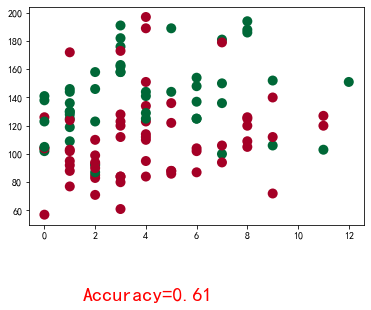

accuracy score is: 0.6111111111111112
precision score is: 0.5652173913043478
recall score is: 0.5416666666666666
auc: 0.6041666666666667
- - - - - - 


In [ ]:
# xtest=torch.from_numpy(xtest.values)
# ytest=torch.from_numpy(ytest.values)
out = net(xtest)     # 喂给 net 训练数据 x, 输出分析值

loss = loss_func(out, ytest)     # 计算两者的误差

optimizer.zero_grad()   
loss.backward()         
optimizer.step()        

# 可视化展示
plt.cla()
# 过了一道 softmax 的激励函数后的最大概率才是预测值
prediction = torch.max(F.softmax(out), 1)[1]

pred_y = prediction.data.numpy().squeeze()
target_y = ytest.data.numpy()
plt.scatter(xtest.data.numpy()[:, 0], xtest.data.numpy()[:, 1], c=pred_y, s=100, lw=0, cmap='RdYlGn')
accuracy = sum(pred_y == target_y) /108   # 计算准确度
plt.text(1.5, -4, 'Accuracy=%.2f' % accuracy, fontdict={'size': 20, 'color': 'red'})
plt.pause(0.1)
print(f'accuracy score is: {accuracy_score(pred_y,target_y)}')
print(f'precision score is: {precision_score(pred_y,target_y)}')
print(f'recall score is: {recall_score(pred_y,target_y)}')
print(f'auc: {roc_auc_score(pred_y,target_y)}')
print('- - - - - - ')

In [69]:
mean=(accuracy_score(pred_y,target_y)+precision_score(pred_y,target_y)+recall_score(pred_y,target_y)+roc_auc_score(pred_y,target_y))/4
print(mean)

0.7233672387120929


In [70]:
#模型保存
import pickle
with open('result.pickle','wb') as f:
    pickle.dump(road_logi,f)
with open('result.pickle','rb') as f:
    clf = pickle.load(f)